## 1. Input

#### Data is stored in a Google sheet, sitting on my Google Drive. This script reads data from Google Sheet and returns a list of "about us" urls corresponding to businesses.

In [2]:
from os import getcwd
from os.path import join, abspath
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

def sheets_client():
    credentials_file = abspath(join(getcwd(), 'credentials.json'))
    credentials = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    return gspread.authorize(credentials)

def sheets_get_all_websites():
    wks = sheets_client().open('Business websites').sheet1

    return [ 
        (row[0], row[2])      # Just client name and "about-us" urls needed.
        for row in wks.get_all_values()[1:]
    ]

def sheets_get_dataframe():
    wks = sheets_client().open('Business websites').sheet1

    return pd.DataFrame(wks.get_all_records())

In [3]:
client_data = sheets_get_all_websites()

## 2. Get keyphrases from about us pages

### 2a. EmbedRank

In [7]:
import rocky_config       # This is an in-house environment which enables jean packages and modules
from jean.nlp2.embedrank import embedrank
from jean.data.web import url2text
import pandas as pd

def get_embedrank_phrases(url):
    
    content = url2text(url)
    phrases = embedrank(content)
    
    data = [[i.text, i.score, i.aliases] for i in phrases]
    pd.set_option('display.max_colwidth', 0)
    df = pd.DataFrame.from_records(data, columns = ['Keyphrase', 'Score', 'Aliases'])
    
    return df

### 2b. IBM Watson NLU

In [19]:
import json
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 \
import Features, ConceptsOptions, KeywordsOptions, EntitiesOptions

In [20]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-03-16',
    #iam_api_key='RMcqA2KiX0OiyWFgXnEetnFV-he9-MQwmiJjTJRldFte',
    username = "4b5ce69c-5582-43bd-ac28-35ca8366eb9b",
    password = "KaIk6zlL3tcN",
    url  = "https://gateway.watsonplatform.net/natural-language-understanding/api"
)

In [21]:
def get_ibm_keyphrases(url):
    try:
        response_keyphrases = natural_language_understanding.analyze(
          url=url,
          features=Features(
            keywords=KeywordsOptions(
              sentiment=True,
              emotion=True,
              limit=10)))
    except:
        response_keyphrases = 0
        
    return response_keyphrases


def get_ibm_concepts(url):
    try:
        response_concepts = natural_language_understanding.analyze(
          url=url,
          features=Features(
            concepts=ConceptsOptions(
              limit=10)))
    except:
        response_concepts = 0
        
    return response_concepts



def get_ibm_entities(url):
    try:
        response_entities = natural_language_understanding.analyze(
          url=url,
          features=Features(
            entities=EntitiesOptions(
              sentiment=True,
              emotion=True,
              limit=10)))
    except:
        response_entities = 0
        
    return response_entities

In [317]:
ibm_en = get_ibm_entities(client_data[0][1])['entities']
data_en = [[i['text'], i['relevance'], i['type'], i['count']] for i in ibm_en]
pd.DataFrame.from_records(data_en, columns = ['entity', 'relevance', 'entity type', 'frequency'])

,entity,relevance,entity type,frequency
0,RedZed Lending Solutions,0.845405,Company,2
1,Lighthouse Foundation,0.460908,Organization,1
2,Lighthouse,0.410309,Company,1
3,partner,0.354174,JobTitle,1
4,Australia,0.334016,Location,1


In [318]:
ibm_con = get_ibm_concepts(client_data[0][1])['concepts']
data_con = [[i['text'], i['relevance'], i['dbpedia_resource']] for i in ibm_con]
pd.DataFrame.from_records(data_con, columns = ['concept', 'relevance', 'dbpedia link'])

,concept,relevance,dbpedia link
0,Debt,0.919186,http://dbpedia.org/resource/Debt
1,Credit,0.795683,http://dbpedia.org/resource/Credit
2,Interest,0.724839,http://dbpedia.org/resource/Interest
3,Predatory lending,0.672455,http://dbpedia.org/resource/Predatory_lending
4,Secured loan,0.672140,http://dbpedia.org/resource/Secured_loan
5,English-language films,0.662739,http://dbpedia.org/resource/English-language_films
6,Youth,0.638040,http://dbpedia.org/resource/Youth
7,Bond,0.588756,http://dbpedia.org/resource/Bond_(finance)
8,Loan,0.559353,http://dbpedia.org/resource/Loan
9,Credit,0.558895,http://dbpedia.org/resource/Credit_(finance)


## 3. Query EventRegistry

#### 3a. API access

In [320]:
from eventregistry import *
from functional import pseq, seq

In [72]:
er = EventRegistry(apiKey = '42640197-4cec-40d7-9abf-264a4e7badea')

using user provided API key for making requests
Event Registry host: http://eventregistry.org
Text analytics host: http://analytics.eventregistry.org


#### 3b. Utilities around EventRegistry

In [321]:
#Separate keywords with and without dbpedia concepts
def concept_separation(keyword_list):
    words_noConceptUri = []
    words_withConceptUri = []

    for i in range(len(keyword_list)):
        temp = er.getConceptUri(keyword_list[i])
        try:
            if ' '.join(temp[-len(keyword_list[i]):].split('_')) != keyword_list[i] or temp is None:
                words_noConceptUri.append(keyword_list[i])
            
            else:
                words_withConceptUri.append(keyword_list[i])
        except:
            words_noConceptUri.append(keyword_list[i])
            
    return ([words_withConceptUri, words_noConceptUri])

In [322]:
def query_article(word_list_uri, words_noConcept, start, end):
    
    q = QueryArticles(
                    dateStart = start,
                    dateEnd = end,
                    conceptUri = QueryItems.OR(word_list_uri),
                    keywords = QueryItems.OR(words_noConcept),
                    lang = "eng")
            
    a = RequestArticlesInfo(page = 1,
                            count = 100,
                            sortBy = "rel", 
                            sortByAsc = False,
                            returnInfo = ReturnInfo(
                                                    articleInfo = ArticleInfoFlags(
                                                                                    concepts = True,
                                                                                    url = True,
                                                                                    title = True,
                                                                                    body = True,  
                                                                                    #dataType = True,
                                                                                    sentiment = True,
                                                                                    #source = True,
                                                                                    categories = True,
                                                                                    links = True,
                                                                                    videos = True,
                                                                                    #lang = True,
                                                                                    location = True,
                                                                                    #sim = True,
                                                                                    #shares = True
                                                                                  ), 
                                                    conceptInfo = ConceptInfoFlags()
                                                    )
                           )
    
    q.setRequestedResult(a)
    
    return(er.execQuery(q))

In [323]:
#QueryArticles
def get_top_concepts(entities, last_month, last_week, p3):
    
    [words_withConceptUri, words_noConceptUri] = concept_separation(entities)
    word_list_uri = [er.getConceptUri(i) for i in entities]
    
    #Initializing
    q_res_combined = 0
    q_res_combined_lw = 0
    q_res_combined_p3 = 0
    
    #With Concepts and No concepts: 
    if last_month:
        print("Querying for last month.....")
        start = datetime.datetime.now() + datetime.timedelta(-28)
        end = datetime.datetime.now()
        q_res_combined = query_article(word_list_uri, words_noConceptUri, start, end)
        #q_res_combined = seq(list(q_res_combined['conceptAggr']['results']))
        
    if last_week:
        print("Querying for last week.....")
        start = datetime.datetime.now() + datetime.timedelta(-7)
        end = datetime.datetime.now()
        q_res_combined_lw = query_article(word_list_uri, words_noConceptUri, start, end)
        #q_res_combined_lw = seq(list(q_res_combined_lw['conceptAggr']['results']))
        
    if p3:
        print("Querying for 3 weeks before last week.....")
        start = datetime.datetime.now() + datetime.timedelta(-28)
        end = datetime.datetime.now() + datetime.timedelta(-8)
        q_res_combined_p3 = query_article(word_list_uri, words_noConceptUri, start, end)
        #q_res_combined_p3 = seq(list(q_res_combined_p3['conceptAggr']['results']))
      
    return ([q_res_combined, q_res_combined_lw, q_res_combined_p3, word_list_uri])

#### 3c. Query EventRegistry using IBM NLU's concepts

In [324]:
data_con = [i['text'] for i in ibm_con]
data_con = [i.lower() for i in data_con]

In [327]:
[q_month, q_lw, q_p3, word_list] = get_top_concepts(data_con, 0, 1, 1)

Querying for last week.....
Querying for 3 weeks before last week.....


In [333]:
data_articles = [[q_lw['articles']['results'][i]['date'], q_lw['articles']['results'][i]['time'], 
q_lw['articles']['results'][i]['dataType'], q_lw['articles']['results'][i]['url'],
q_lw['articles']['results'][i]['title'], #q_lw['articles']['results'][i]['body'],
q_lw['articles']['results'][i]['source']['title'], q_lw['articles']['results'][i]['location'],
q_lw['articles']['results'][i]['sentiment'], q_lw['articles']['results'][i]['wgt']] 
        for i in range(len(q_lw['articles']['results']))]

labels = ['date', 'time', 'dataType', 'url', 'title', 'source', 'location', 'sentiment', 'wgt']
df_lw = pd.DataFrame.from_records(data_articles, columns = labels)
df_lw.head(5)

,date,time,dataType,url,title,source,location,sentiment,wgt
0,2018-07-09,21:41:00,blog,https://articles.bplans.com/get-a-business-credit-card-to-build-your-startups-credit/,Get a Business Credit Card to Build Your Startup's Credit - Bplans Blog,Bplans Blog,None,None,365
1,2018-07-12,14:50:00,news,https://www.johnnyjet.com/check-credit-inquiries-credit-report/,How To Check Credit Inquiries On Your Credit Report,Johnny Jet,None,None,306
2,2018-07-15,09:33:00,news,https://www.dailyrepublic.com/all-dr-news/wires/business/how-to-get-a-credit-card-when-youve-never-had-one/,How to get a credit card when you've never had one,Daily Republic,None,None,299
3,2018-07-10,19:20:00,blog,https://columbustelegram.com/business/investment/personal-finance/should-you-pay-off-debt-or-should-you-save-and/article_3b34feac-0d63-5645-99ad-f557140ccf38.html,"Should You Pay Off Debt, or Should You Save and Invest?",Columbus Telegram,None,None,274
4,2018-07-12,18:56:00,blog,https://www.merchantmaverick.com/5-ways-improve-personal-credit-score/,5 Ways To Improve Your Personal Credit Score | Merchant Maverick,Merchant Maverick,None,None,270


In [334]:
data_p3 = [[q_p3['articles']['results'][i]['date'], q_p3['articles']['results'][i]['time'], 
q_p3['articles']['results'][i]['dataType'], q_p3['articles']['results'][i]['url'],
q_p3['articles']['results'][i]['title'], #q_lw['articles']['results'][i]['body'],
q_p3['articles']['results'][i]['source']['title'], q_p3['articles']['results'][i]['location'],
q_p3['articles']['results'][i]['sentiment'], q_p3['articles']['results'][i]['wgt']] 
        for i in range(len(q_p3['articles']['results']))]

labels = ['date', 'time', 'dataType', 'url', 'title', 'source', 'location', 'sentiment', 'wgt']
df_p3 = pd.DataFrame.from_records(data_articles, columns = labels)

## 4. Analyze and Rank the news articles according to cosine similarity with the URL's content

#### 4a. date wise count of articles 

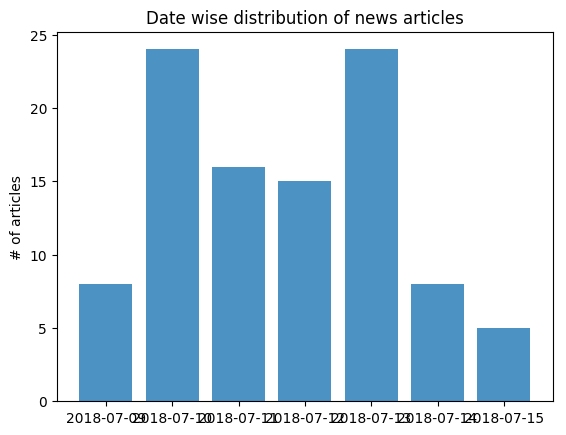

In [401]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = sorted(list(set(df['date'])))
y_pos = np.arange(len(objects))
performance = list(df.groupby('date').size())
 
plt.bar(y_pos, performance, alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('# of articles')
plt.title('Date wise distribution of news articles')
 
plt.show()

#### 4b. time wise count of articles - group by morning, afternoon and evening

In [336]:
morning = 0
afternoon = 0
evening = 0

for i in range(len(df['time'])):
    if df_lw['time'][i] >= '00:00:00' and df_lw['time'][i] <= '12:00:00':
        morning = morning + 1
    elif df_lw['time'][i] > '12:00:00' and df_lw['time'][i] <= '18:00:00':
        afternoon = afternoon + 1
    else:
        evening = evening + 1

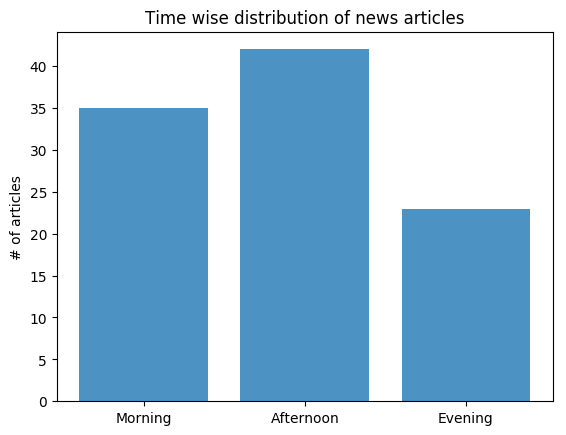

In [402]:
objects = ['Morning', 'Afternoon', 'Evening']
y_pos = np.arange(len(objects))
performance = [morning, afternoon, evening]
 
plt.bar(y_pos, performance, alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('# of articles')
plt.title('Time wise distribution of news articles')
 
plt.show()

#### 4c. data type wise count - pr, news, blog

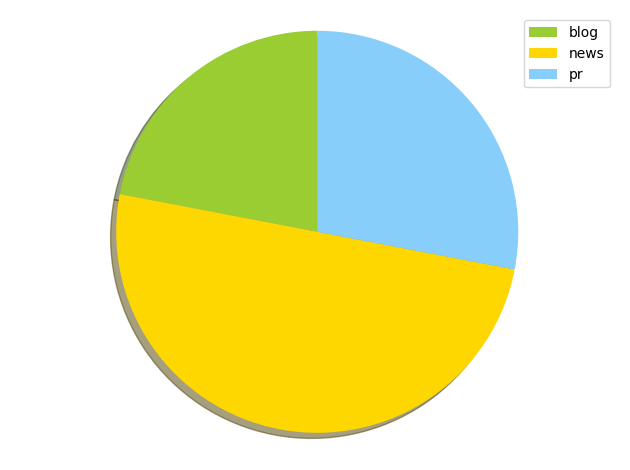

In [405]:
import matplotlib.pyplot as plt
 
labels = sorted(list(set(df_lw['dataType'])))
sizes = list(df_lw.groupby('dataType').size())
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

#### 4d. source count

In [338]:
len(set(df_lw['source']))

53

#### 4e. cosine similarity with title, docemb of content

In [339]:
from jean.nlp2.embeddings import embed_document, embed_text
from sklearn.metrics.pairwise import cosine_similarity
from jean.data.web import url2text

titles = list(df_lw['title'])

emb_titles = [embed_text(i) for i in titles]

content = url2text(client_data[0][1])
doc_emb = embed_document(content)

sims_titles = [float(cosine_similarity(doc_emb, i.reshape(1,-1))) for i in emb_titles]

#ranked_titles = [x for _,x in sorted(zip(sims_titles,titles), reverse = True)]
data = [[titles[i], sims_titles[i]] for i in range(len(sims_titles))]
df_ranked = pd.DataFrame.from_records(data, columns = ['title', 'relevance']).sort_values(by = ['relevance'], ascending = False)
df_ranked[:10]

,title,relevance
63,Deduction U/s. 80P(2)(d) eligible to Co-operative society on Interest from co-operative banks despite not providing credit facilities to members,0.417757
59,Remodeling your home? Good credit offers a strong foundation,0.413251
98,How do late payments affect your credit score?,0.387905
54,"New grads, unlock your future with a credit checkup",0.351911
53,"New grads, unlock your future with a credit checkup",0.351911
11,Can Delhi HC decision block migration of KKC?,0.351008
91,Should you have multiple credit cards? Here are the benefits and drawbacks,0.350186
92,Smart ways to evaluate your credit score,0.343396
20,4 ways to build good credit without using a credit card,0.333768
46,One way to beat the system when claiming tax breaks for education under the new tax law,0.311758


#### 4f. cosine similarity with body, docemb of content

In [341]:
body = [q_lw['articles']['results'][i]['body'] for i in range(len(q_lw['articles']['results']))]

emb_body = [embed_document(i) for i in body]

sims_body = [float(cosine_similarity(doc_emb, i)) for i in emb_body]

data = [[titles[i], sims_body[i]] for i in range(len(sims_body))]
df_ranked = pd.DataFrame.from_records(data, columns = ['title', 'relevance']).sort_values(by = ['relevance'], ascending = False)
df_ranked[:10]

,title,relevance
21,What Happens When You Stop Paying Your Student Loans,0.742873
45,Senior Youth Workforce Development Advisor (American Citizens ONLY),0.734073
9,Farmland Partners: Loans To Related-Party Tenants Introduce Significant Risk Of Insolvency - Shares Uninvestible,0.733826
80,American United FCU and Finex Credit Union to Offer CU RateReset Products,0.729843
47,"What The End Of The Credit Cycle May Look Like, And How To Trade It",0.724607
49,Say Yes to Payday Loan Debt Consolidation - Cascade Business News,0.722297
7,Wells Fargo Reports $5.2 Billion in Quarterly Net Income,0.716360
22,Credible Review: Is it Worth it to Refinance Your Debt?,0.715146
50,Libra Credit and Uphold Partner to Bring Credit to Everyone,0.713195
87,"The PNC Financial Services Group, Inc. (PNC) CEO William Demchak on Q2 2018 Results - Earnings Call Transcript",0.712602


## 5. Query Twitter

#### 5a. Twitter Authentication

In [345]:
CLIENT_ID = 'Kd1Iu7AaVQFiZMZwsT12fKQ72'
CLIENT_SECRET = 'qTw1SIYvzqrXdarBLwa3i2AbqVCBgjMgCJ5aaamh5TqUOIuRZQ'
ACCESS_TOKEN = '841105681616838656-jCxi1UYfnOEbD7LxOxBR9uASrmpGtka'
ACCESS_SECRET = 'lJhj81dEt4gprJ3wvP9V8miq9lGOln2O0TrDPYD2qaMQp'

In [346]:
import tweepy
auth = tweepy.OAuthHandler(CLIENT_ID, CLIENT_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

#### 5b. Get data (tweets)

In [347]:
def get_tweets(query_term):
    results = []
    for tweet in tweepy.Cursor (api.search, q = query_term, lang = "en").items(2000): 
        results.append(tweet)
    return results

In [348]:
tweets_kc = get_tweets(' OR '.join([f'"{term}"' for term in data_con]))

In [360]:
all_tweets = [tweets_kc[i].text for i in range(len(tweets_kc))]

#### 5c. Clean Tweets

In [349]:
import preprocessor as p
def clean_tweets_glove(tweets):
    cleaned_tweets = []
    for i in range(len(tweets)):  # Replace with tweets_kc if cleaning a new set of tweets
        cleaned_tweets.append(p.clean(tweets[i])) # Replace with tweets_kc[i].text
    unique_cleaned_tweets = list(set(cleaned_tweets))
    return unique_cleaned_tweets

In [366]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def stop_word_removal(cleaned_tweets):
    cleaned_tweets_nosw = []
    stop_words = set(stopwords.words('english'))
    for i in range(len(cleaned_tweets)):
        word_tokens = word_tokenize(cleaned_tweets[i])
        filtered_words = [word for word in word_tokens if word not in stopwords.words('english')]
        cleaned_tweets_nosw.append(' '.join(filtered_words))
    return cleaned_tweets_nosw

In [367]:
cleaned_tweets = clean_tweets_glove(all_tweets)
cleaned_tweets = stop_word_removal(cleaned_tweets)

#### 5d. Find trending topics within tweets

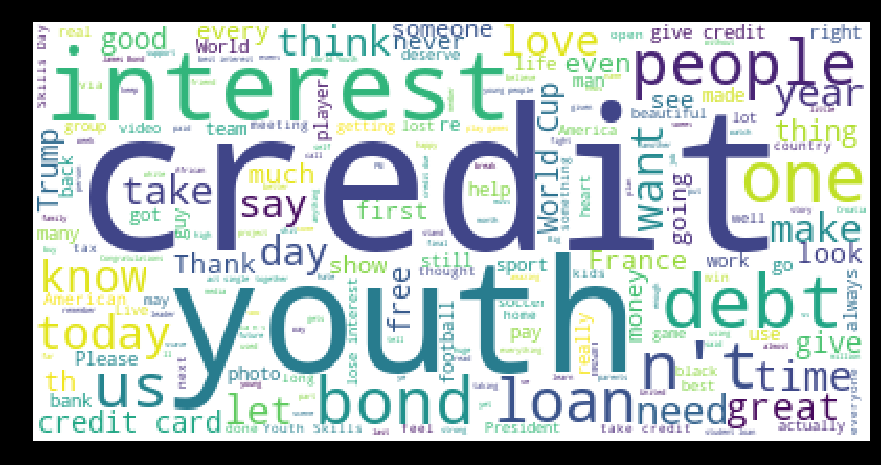

In [370]:
# Word Cloud visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud(tweets,col):
    stopwords = set(STOPWORDS).union(set(["new" , "amp", "il", "da", "al", "del", "di", "la", "per"]))
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate('. '.join(cleaned_tweets))
    plt.figure( figsize=(15,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Good Morning Datascience+")

wordcloud(cleaned_tweets,'text')  

In [371]:
# Topic Modeling on cleaned_tweets
cleaned_tweets_doc = '. '.join(cleaned_tweets)
#Cleaning and Preprocessing
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english') + ["rt"] + ["amp"] + ["u"] + ["it"])
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in cleaned_tweets_doc] 

In [372]:
#Prepare Doc-Term Matrix
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [373]:
#Run LDA
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=10)

In [374]:
ldamodel.print_topics(num_words=10)

[(0,
  '0.997*"c" + 0.000*"→" + 0.000*"í" + 0.000*"🤗" + 0.000*"！" + 0.000*"【" + 0.000*"🤔" + 0.000*"🥂" + 0.000*"\u2069" + 0.000*"\u2066"'),
 (1,
  '0.531*"w" + 0.459*"v" + 0.006*"🇺" + 0.000*"\u200d" + 0.000*"🤷" + 0.000*"🇲" + 0.000*"⏩" + 0.000*"→" + 0.000*"í" + 0.000*"🤗"'),
 (2,
  '0.530*"g" + 0.254*"k" + 0.213*"…" + 0.001*"—" + 0.000*"→" + 0.000*"í" + 0.000*"🤗" + 0.000*"！" + 0.000*"【" + 0.000*"🤔"'),
 (3,
  '0.990*"e" + 0.009*"q" + 0.000*"→" + 0.000*"í" + 0.000*"🤗" + 0.000*"！" + 0.000*"【" + 0.000*"🤔" + 0.000*"🥂" + 0.000*"\u2066"'),
 (4,
  '0.998*"r" + 0.000*"→" + 0.000*"í" + 0.000*"🤗" + 0.000*"！" + 0.000*"【" + 0.000*"🤔" + 0.000*"🥂" + 0.000*"\u2069" + 0.000*"\u2066"'),
 (5,
  '0.998*"n" + 0.000*"→" + 0.000*"í" + 0.000*"🤗" + 0.000*"！" + 0.000*"【" + 0.000*"🤔" + 0.000*"🥂" + 0.000*"\u2069" + 0.000*"\u2066"'),
 (6,
  '0.942*"p" + 0.039*"z" + 0.014*"”" + 0.001*"🤗" + 0.000*"→" + 0.000*"í" + 0.000*"！" + 0.000*"【" + 0.000*"🤔" + 0.000*"🥂"'),
 (7,
  '0.708*"f" + 0.070*"x" + 0.057*"0" + 0.025*"1" + 0

#### 5e. Hashtag Analysis

In [389]:
ibm_kp = get_ibm_keyphrases(client_data[0][1])['keywords']
data_kp = [i['text'] for i in ibm_kp]
data_kp = [i.lower() for i in data_kp]

terms = data_con
phrases = data_kp
all_terms = terms + phrases

In [390]:
tweets_keyconcepts = get_tweets(' OR '.join([f'"{term}"' for term in all_terms]))

In [391]:
#Store tweets data in a dataframe

def tweets_df(results):
    id_list = [tweet.id for tweet  in results]
    data_set = pd.DataFrame(id_list, columns = ["id"])
    
    data_set["text"] = [tweet.text for tweet in results]
    data_set["created_at"] = [tweet.created_at for tweet in results]
    data_set["retweet_count"] = [tweet.retweet_count for tweet in results]
    data_set["user_screen_name"] = [tweet.author.screen_name for tweet in results]
    data_set["user_followers_count"] = [tweet.author.followers_count for tweet in results]
    data_set["user_location"] = [tweet.author.location for tweet in results]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in results]
    
    return data_set

data_set = tweets_df(tweets_keyconcepts)


# Remove tweets with duplicate text

text = data_set["text"]

for i in range(0,len(text)):
    txt = ' '.join(word for word in text[i] .split() if not word.startswith('https:'))
    data_set.set_value(i, 'text2', txt)
    
data_set.drop_duplicates('text2', inplace=True)
data_set.reset_index(drop = True, inplace=True)
data_set.drop('text', axis = 1, inplace = True)
data_set.rename(columns={'text2': 'text'}, inplace=True)

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [392]:
Htag_df = pd.DataFrame()
j = 0

for tweet in range(0,len(tweets_keyconcepts)):
    hashtag = tweets_keyconcepts[tweet].entities.get('hashtags')
    for i in range(0,len(hashtag)):
        Htag = hashtag[i]['text'] 
        Htag_df.set_value(j, 'Hashtag',Htag)
        j = j+1

/home/pan/anaconda3/envs/jean-research/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [395]:
#key concepts
Htag_df.apply(pd.value_counts).head(5)

,Hashtag
WorldCupFinal,24
ChicagoPolice,9
Sherlock,7
EddieJohnson,6
FRA,6


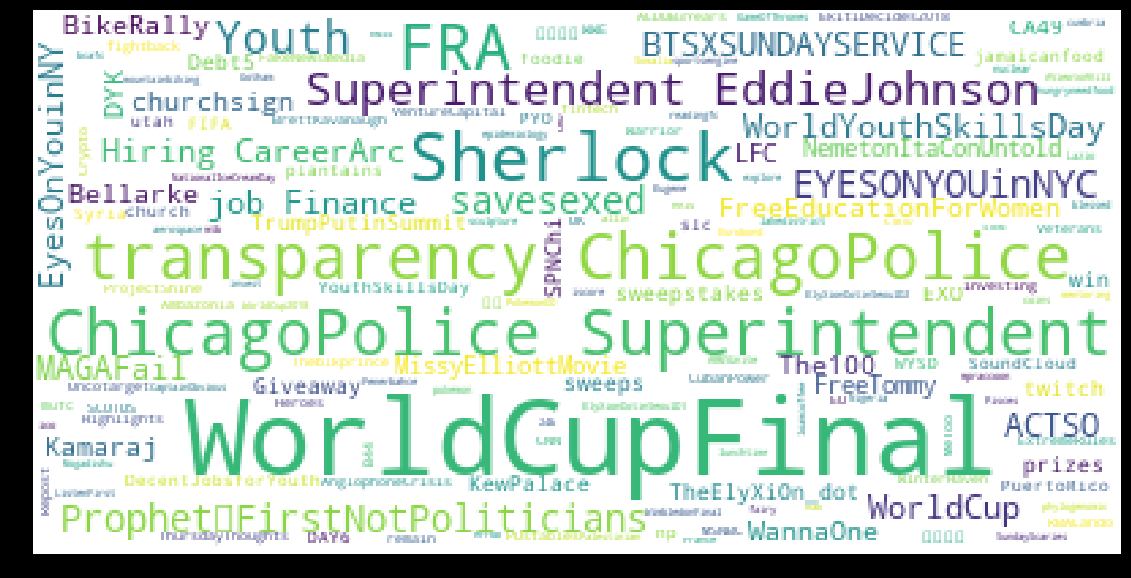

In [394]:
# Visualize
# Join all the text from the 1000 tweets
Hashtag_Combined = " ".join(Htag_df['Hashtag'].values.astype(str))


#no_r1 = " ".join([word for word in Hashtag_Combined.split()
                               # if word != 'millennials'
                               # and word != 'Millennials'
                               # and word != 'Boomers'
                               # and word != 'GenX'
                                                                
                               # ])

#Tweet_mask = imread("C:\\Users\\kdudani\\Desktop\\Personal\\Social Media Analytics\\twitter_mask.png", flatten=True)

#Create a Word Cloud
wc = WordCloud(background_color="white", stopwords=STOPWORDS)
wc.generate(Hashtag_Combined)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wc)
plt.axis("off")
#plt.savefig('C:\\Users\\kdudani\\Desktop\\Personal\\Social Media Analytics\\millennials_Hashtag.png', dpi=300)
plt.show()

#### 5f. Semantic similarity of tweets with about us page

In [396]:
emb_tweets = [embed_text(i) for i in cleaned_tweets]

sims_tweets = [float(cosine_similarity(doc_emb, i.reshape(1,-1))) for i in emb_tweets]

#ranked_titles = [x for _,x in sorted(zip(sims_titles,titles), reverse = True)]
data = [[cleaned_tweets[i], sims_tweets[i]] for i in range(len(sims_tweets))]
df_rankedtweets = pd.DataFrame.from_records(data, columns = ['tweet', 'relevance']).sort_values(by = ['relevance'], ascending = False)
df_rankedtweets[:10]

,tweet,relevance
884,: Here thing know payday loans alternatives consider .,0.524473
1185,So appreciate supportive credit card content providers industry specialists . Making connections indu…,0.491527
760,"Private equity firms pumping unprecedented amount money companies offering therapy , includin…",0.490895
660,"When donate vehicle help children need , receive tax credit . One representatives will…",0.485091
91,: When student loan problem become crisis Americans responsible Democrat Senator Elizabeth…,0.483132
645,I live sort road someone uses ‘ know credit rating ? ’ comeback argument tbh goals,0.478253
933,"state take loan finance project , mean project belongs t…",0.476180
1078,"Bank credit might fuel asset inflation , bring instability financial markets rampant inequal…",0.469611
1141,: I restricted wages poverty one year conjunction disability-related student loan forgiveness.…,0.469209
89,Your battery percentage chance getting rlc back loan . Mine saying % haha,0.468146
